In [5]:
from src.data.datamanager import DataManager
from src.data.window import WindowSequence, KerasSequence
from src.data.dataset import MotionSense, Activity
from src.visual.plotter import Plotter, VecData
from keras.optimizers import SGD, Adam, RMSprop
from pathlib import Path
import toml
datasets = toml.load("config.toml")["dataset"]
WISDM_PATH = Path(datasets["wisdm"])
MOTION_SENSE_PATH = Path(datasets["motion-sense"])
dataset = MotionSense(MOTION_SENSE_PATH)
datamanager = DataManager(dataset)
all_data=datamanager.read()
window_length = 100
windows = datamanager.create_windows(set(Activity), window_length, shuffle=True, seed=1, columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm'])#, bypass_raw="6a3bf91cfb")
# windows = datamanager.create_windows(set(Activity), 100, shuffle=False, seed=1, columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm', "activity"])#, bypass_raw="6a3bf91cfb")
seq = windows.to_keras_sequence(32)


In [82]:
num_classes=windows.num_classes
n_latents = 200

In [2]:
import numpy
from numpy.random import random

In [64]:
# Load real classifier
from keras.models import load_model

# load model
classifier = load_model('models/classifiers/cnn_classifier.h5')

In [291]:
def generate_labels(n_samples: int, num_classes: int, onehot: bool) -> numpy.ndarray:
    if onehot:
        return numpy.eye(num_classes)[
            numpy.random.choice(num_classes, n_samples)
        ]
    return numpy.random.randint(0, num_classes, (n_samples, 1))

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + random(y.shape) * 0.3


def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * y.shape[0])
    # choose labels to flip
    flip_ix = numpy.random.choice([i for i in range(y.shape[0])], size=n_select)
    # invert the labels in place
    y[flip_ix] = 1 - y[flip_ix]
    return y

# generate points in latent space as input for the generator
#Gaussian values with a mean close to zero and a 
#standard deviation close to 1, e.g. a standard Gaussian distribution.
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = numpy.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape((n_samples, latent_dim))
    return x_input

def create_ground_values(n_samples: int):
    return (
        numpy.clip(noisy_labels(smooth_positive_labels(numpy.ones((n_samples, 1))), 0.05), 0, 1.2),
        numpy.clip(noisy_labels(smooth_negative_labels(numpy.zeros((n_samples, 1))), 0.05), 0, 1.2),
    )

In [411]:
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def confusion(y_pred, y_true, classes, title=None, xlabel=None, ylabel=None, norm="pred"):
    data = confusion_matrix(y_true, y_pred, labels=[i for i in range(len(classes))], normalize=norm)
    if norm:
        data = data*100
    
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(9, 6))
    h = sns.heatmap(data, annot=True, fmt=".1f" if norm else "d", linewidths=.5, ax=ax)
    h.set(xticklabels=classes, yticklabels=classes)
    if title:
        h.set(title=title)
    if xlabel:
        h.set(xlabel=xlabel)
    if ylabel:
        h.set(ylabel=ylabel)
        

In [517]:
def disc_fr_confusion(X_gen, X_real, discriminator, normalize=None):
    # disc fake/real conf matrix
    X = numpy.concatenate([X_gen, X_real])
    Y = numpy.concatenate([
        numpy.zeros((X_gen.shape[0], 1)), 
        numpy.ones((X_real.shape[0], 1))
    ])
    Y_pred = discriminator.predict(X)[0]
    Y_pred = numpy.round(Y_pred)
    confusion(Y_pred, Y, ["FAKE", "REAL"], title="Fake/Real Discrimination", xlabel="Discrimination", ylabel="Generated", norm=normalize)

def disc_classification_confusion(X, Y, discriminator, classes, title=None, normalize=None):
    Y_pred = discriminator.predict(X)[1]
    Y_pred = Y_pred.argmax(axis=1)
    confusion(Y_pred, Y, classes, title=title if title else "Class Discrimination", xlabel="Prediction", ylabel="Given", norm=normalize)
    
def disc_fooled_classification_confusion(X_gen, Y_gen, discriminator, classes, title=None, normalize=None):
    Y_pred_fakereal, Y_pred_classes = discriminator.predict(X_gen)
    Y_pred_fakereal_fooled = numpy.delete(Y_pred_fakereal, numpy.where(Y_pred_fakereal < 0.5), axis=0)
    Y_pred_classes_fooled = numpy.delete(Y_pred_classes, numpy.where(Y_pred_fakereal < 0.5), axis=0).argmax(axis=1)
    Y_gen_fooled = numpy.delete(Y_gen, numpy.where(Y_pred_fakereal < 0.5), axis=0)
    confusion(Y_pred_classes_fooled, Y_gen_fooled, classes, title=title if title else "Classificate Succesfuly Generated Data with Discriminator", xlabel="Prediction", ylabel="Successfully Generated", norm=normalize)
    

def classifier_fooled_classification_confusion(X_gen, Y_gen, discriminator, classes, clf, title=None, normalize=None):  
    Y_pred_fakereal, _ = discriminator.predict(X_gen)
    Y_gen_fooled = numpy.delete(Y_gen, numpy.where(Y_pred_fakereal < 0.5), axis=0)
    X_gen_fooled = numpy.delete(X_gen, numpy.where(Y_pred_fakereal < 0.5), axis=0)
    Y_pred_classes = clf.predict(X_gen_fooled)
    if type(Y_pred_classes) == list:
        return
    Y_pred_classes = Y_pred_classes.argmax(axis=1)
    confusion(Y_pred_classes, Y_gen_fooled, classes, title=title if title else "Classificate Successfuly Generated Data with Real Classifier", xlabel="Prediction", ylabel="Successfully Generated", norm=normalize)


In [287]:
import matplotlib.pyplot as plt

def loss_plots(d_losses, g_losses):
    # multiple line plot
    plt.plot(numpy.arange(len(d_losses)), d_losses, label="D Loss", marker='', color='skyblue', linewidth=2)
    plt.plot(numpy.arange(len(g_losses)), g_losses, label="G Loss", marker='', color='olive', linewidth=2)
    plt.legend()


In [561]:
del plot_model

from keras.utils import plot_model

def plot_gan(gan):
    dot_img_file = '/tmp/model.png'
    plot_model(gan, to_file=dot_img_file, show_shapes=True)

In [460]:
def generate_and_prepare_data(generator, n_samples_each=100):

    latents = generate_latent_points(n_latents, n_samples_each * num_classes)
    Y_gen = numpy.array([[i]*n_samples_each for i in range(num_classes)]).flatten()
    X_gen = generator.predict([latents, Y_gen])

    window_sample = datamanager.create_windows(
        set(Activity), 
        window_length, 
        shuffle=True,
        columns=['xaccel_norm', 'yaccel_norm', 'zaccel_norm', 'xrot_norm', 'yrot_norm', 'zrot_norm'])
    seq_sample = windows.to_keras_sequence(n_samples_each * num_classes)

    X_real = seq_sample[0][0]
    Y_real = seq_sample[0][1]
    
    return X_real, Y_real, X_gen, Y_gen

In [461]:
def after_training(gan, normalize=None):
    plot_gan(gan)
    X_real, Y_real, X_gen, Y_gen = generate_and_prepare_data(gan.generator, 300)
    loss_plots(gan.d_losses, gan.g_losses)
    disc_fr_confusion(X_gen, X_real, gan.discriminator, normalize=normalize)
    disc_classification_confusion(X_real, Y_real.argmax(axis=1), gan.discriminator, sorted(dataset.ACTIVITIES.values()), title="Discriminating Labels of REAL Values", normalize=normalize)
    disc_classification_confusion(X_gen, Y_gen, gan.discriminator, sorted(dataset.ACTIVITIES.values()), title="Discriminating Labels of FAKE Values", normalize=normalize)
    disc_fooled_classification_confusion(X_gen, Y_gen, gan.discriminator, sorted(dataset.ACTIVITIES.values()), title="Class Discriminations of Successfuly Generated Values", normalize=normalize)
    classifier_fooled_classification_confusion(X_gen, Y_gen, gan.discriminator, sorted(dataset.ACTIVITIES.values()), classifier, normalize=normalize)

In [462]:
from src.data.window import NumpySequences
from keras import backend
from keras.layers import (
    LSTM,
    BatchNormalization,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    Layer,
    Lambda,
    LeakyReLU,
    Reshape,
    multiply,
    Softmax, 
    Conv1D, 
    MaxPooling1D,
    AveragePooling1D,
    UpSampling1D,
    ZeroPadding1D,
    Activation
)
from keras.models import Sequential, Model


class GAN:
    
    def __init__(self):
        self.d_losses = []
        self.d_accs = []
        self.g_losses = []
    
    def train(self, data: NumpySequences, num_epochs: int) -> None:
        
        # Adversarial ground truths
        ground_real, ground_fake = create_ground_values(data.batch_size)

        training_step = 0
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            for batch, (real_sequences, real_classes) in enumerate(data):
                d_loss, d_accuracy, cls_accuracy, g_loss = self.batch_step(
                    real_sequences, real_classes, ground_real, ground_fake
                )
                if numpy.isnan(d_loss) or numpy.isnan(g_loss):
                    print(
                        f"NaN's detected in the result: d_loss:{d_loss}, d_accuracy:{d_accuracy}, g_loss:{g_loss}"
                    )
                    return

                training_step += 1

            print(f"[Disc loss: {d_loss:2.3f}; acc?: %{cls_accuracy:.1%}] [G loss: {g_loss:2.3f}]")
            self.d_losses.append(d_loss)
            self.d_accs.append(d_accuracy)
            self.g_losses.append(g_loss)

        print("Done!")

# ACGANs

## ACGAN 1

In [60]:
class AcGan_1(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        Gan.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(300)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=42, kernel_size=3, input_shape=(self.data_shape))(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)
        y = MaxPooling1D(pool_size=2)(y)
        y = Flatten()(y)
        y = Dropout(0.3)(y)
        y = Dense(120)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.3)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [63]:
acgan_1 = AcGan_1(windows.num_classes, n_latents, seq.shape[-2:])
acgan_1.combined.summary()
acgan_1.generator.summary()
acgan_1.discriminator.summary()
acgan_1.train(seq, 30)

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_103 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_52 (Model)                (None, 100, 6)       606300      input_102[0][0]                  
                                                                 input_103[0][0]                  
__________________________________________________________________________________________________
model_53 (Model)                [(None, 1), (None, 6 248725      model_52[1][0]            

[Disc loss: 1.734; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 2.000]
Starting epoch 7
[Disc loss: 1.599; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 1.618]
Starting epoch 8
[Disc loss: 2.086; Disc acc: %100.0%, Cls acc: %50.0%] [G loss: 2.107]
Starting epoch 9
[Disc loss: 2.177; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 2.082]
Starting epoch 10
[Disc loss: 2.036; Disc acc: %100.0%, Cls acc: %45.3%] [G loss: 2.274]
Starting epoch 11
[Disc loss: 1.930; Disc acc: %100.0%, Cls acc: %42.2%] [G loss: 1.992]
Starting epoch 12
[Disc loss: 2.040; Disc acc: %100.0%, Cls acc: %56.2%] [G loss: 2.287]
Starting epoch 13
[Disc loss: 1.862; Disc acc: %100.0%, Cls acc: %53.1%] [G loss: 2.317]
Starting epoch 14
[Disc loss: 2.014; Disc acc: %100.0%, Cls acc: %51.6%] [G loss: 2.382]
Starting epoch 15
[Disc loss: 1.810; Disc acc: %100.0%, Cls acc: %48.4%] [G loss: 2.331]
Starting epoch 16
[Disc loss: 2.008; Disc acc: %100.0%, Cls acc: %46.9%] [G loss: 2.384]
Starting epoch 17
[Disc loss: 1.990; Disc 

In [545]:
after_training(acgan_1)

AttributeError: 'AcGan' object has no attribute 'd_losses'

Generator lost the battle!

## ACGAN 2

In [272]:
class AcGan_2(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(300)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=42, kernel_size=3, input_shape=(self.data_shape))(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)
        y = MaxPooling1D(pool_size=2)(y)
        y = Flatten()(y)
        y = Dropout(0.3)(y)
        y = Dense(120)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.3)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [273]:
acgan_2 = AcGan_2(windows.num_classes, n_latents, seq.shape[-2:])
acgan_2.combined.summary()
acgan_2.generator.summary()
acgan_2.discriminator.summary()
acgan_2.train(seq, 40)

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_127 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_128 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_67 (Model)                (None, 100, 6)       243300      input_127[0][0]                  
                                                                 input_128[0][0]                  
__________________________________________________________________________________________________
model_68 (Model)                [(None, 1), (None, 6 248725      model_67[1][0]            

[Disc loss: 1.904; Disc acc: %100.0%, Cls acc: %48.4%] [G loss: 2.363]
Epoch 17/40
[Disc loss: 2.098; Disc acc: %100.0%, Cls acc: %46.9%] [G loss: 2.139]
Epoch 18/40
[Disc loss: 1.937; Disc acc: %100.0%, Cls acc: %45.3%] [G loss: 2.319]
Epoch 19/40
[Disc loss: 1.828; Disc acc: %100.0%, Cls acc: %51.6%] [G loss: 2.431]
Epoch 20/40
[Disc loss: 1.851; Disc acc: %100.0%, Cls acc: %54.7%] [G loss: 2.505]
Epoch 21/40
[Disc loss: 1.901; Disc acc: %100.0%, Cls acc: %48.4%] [G loss: 2.559]
Epoch 22/40
[Disc loss: 1.667; Disc acc: %100.0%, Cls acc: %50.0%] [G loss: 2.714]
Epoch 23/40
[Disc loss: 1.966; Disc acc: %100.0%, Cls acc: %43.8%] [G loss: 2.361]
Epoch 24/40
[Disc loss: 2.035; Disc acc: %100.0%, Cls acc: %46.9%] [G loss: 2.535]
Epoch 25/40
[Disc loss: 1.806; Disc acc: %100.0%, Cls acc: %54.7%] [G loss: 2.617]
Epoch 26/40
[Disc loss: 1.896; Disc acc: %100.0%, Cls acc: %43.8%] [G loss: 2.331]
Epoch 27/40
[Disc loss: 1.903; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.160]
Epoch 28/40
[Dis

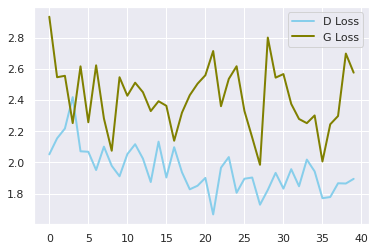

In [288]:
loss_plots(acgan_2.d_losses, acgan_2.g_losses)

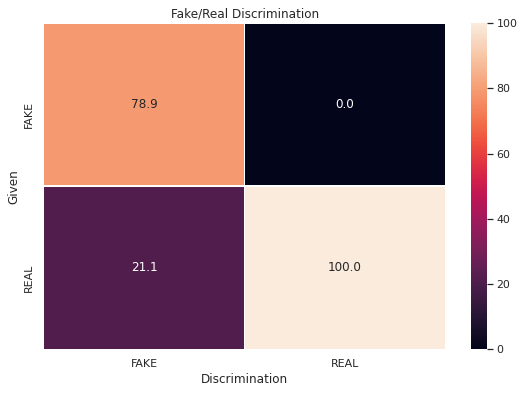

In [274]:
disc_fr_confusion(X_gen, X_real, acgan_2.discriminator)

**Generator couldn't fool the discriminator**

## ACGAN 3

In [289]:
class AcGan_3(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(400)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=42, kernel_size=3, input_shape=(self.data_shape))(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)
        y = MaxPooling1D(pool_size=2)(y)
        y = Flatten()(y)
        y = Dropout(0.3)(y)
        y = Dense(120)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.3)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [292]:
acgan_3 = AcGan_3(windows.num_classes, n_latents, seq.shape[-2:])
acgan_3.combined.summary()
acgan_3.generator.summary()
acgan_3.discriminator.summary()
acgan_3.train(seq, 50)

Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_137 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_138 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_73 (Model)                (None, 100, 6)       243300      input_137[0][0]                  
                                                                 input_138[0][0]                  
__________________________________________________________________________________________________
model_74 (Model)                [(None, 1), (None, 6 248725      model_73[1][0]            

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 2.264; Disc acc: %100.0%, Cls acc: %42.2%] [G loss: 3.011]
Epoch 2/50
[Disc loss: 1.935; Disc acc: %100.0%, Cls acc: %42.2%] [G loss: 3.178]
Epoch 3/50
[Disc loss: 2.025; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.741]
Epoch 4/50
[Disc loss: 2.074; Disc acc: %100.0%, Cls acc: %45.3%] [G loss: 2.184]
Epoch 5/50
[Disc loss: 2.125; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.140]
Epoch 6/50
[Disc loss: 2.127; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 2.081]
Epoch 7/50
[Disc loss: 2.062; Disc acc: %100.0%, Cls acc: %46.9%] [G loss: 2.218]
Epoch 8/50
[Disc loss: 2.212; Disc acc: %100.0%, Cls acc: %45.3%] [G loss: 2.219]
Epoch 9/50
[Disc loss: 2.139; Disc acc: %100.0%, Cls acc: %45.3%] [G loss: 2.171]
Epoch 10/50
[Disc loss: 2.076; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 2.161]
Epoch 11/50
[Disc loss: 1.967; Disc acc: %100.0%, Cls acc: %46.9%] [G loss: 2.578]
Epoch 12/50
[Disc loss: 1.889; Disc acc: %100.0%, Cls acc: %53.1%] [G loss: 2.199]
Epoch 13/50
[Disc loss: 

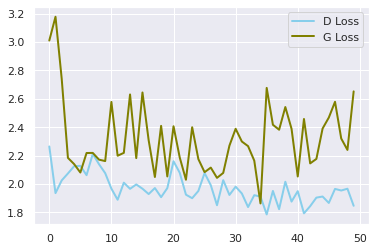

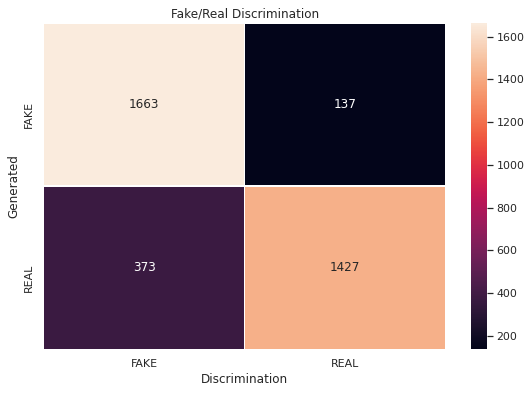

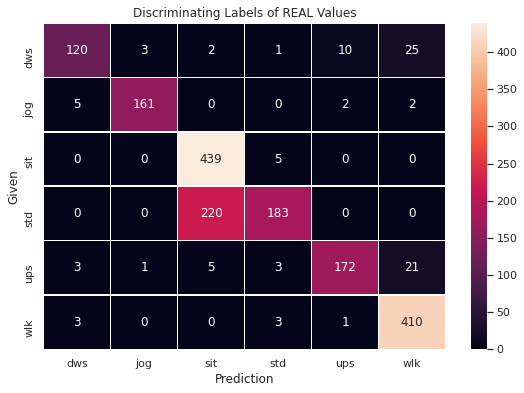

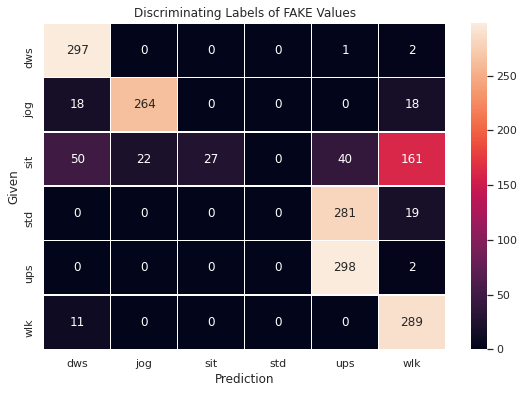

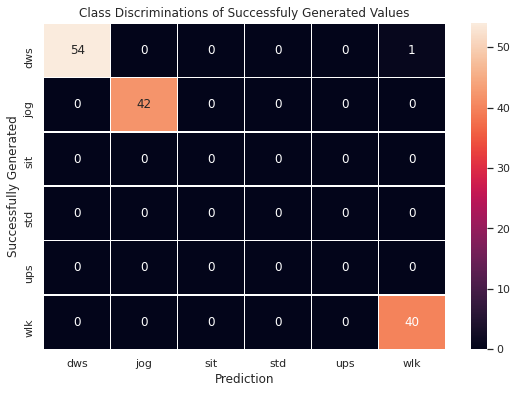

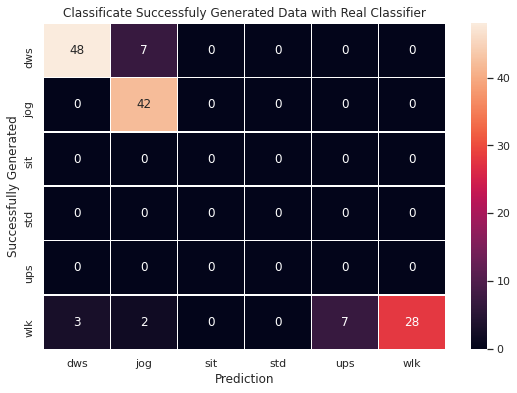

In [542]:
after_training(acgan_3)

In [346]:
class AcGan_4(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(400)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=42, kernel_size=3, input_shape=(self.data_shape))(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)
        y = MaxPooling1D(pool_size=2)(y)
        y = Flatten()(y)
        y = Dropout(0.3)(y)
        y = Dense(120)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.3)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [347]:
acgan_4 = AcGan_4(windows.num_classes, n_latents, seq.shape[-2:])
acgan_4.combined.summary()
acgan_4.generator.summary()
acgan_4.discriminator.summary()
acgan_4.train(seq, 30)

Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_161 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_162 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_85 (Model)                (None, 100, 6)       1775800     input_161[0][0]                  
                                                                 input_162[0][0]                  
__________________________________________________________________________________________________
model_86 (Model)                [(None, 1), (None, 6 248725      model_85[1][0]            

[Disc loss: 1.956; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 3.150]
Epoch 2/30
[Disc loss: 2.005; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 3.440]
Epoch 3/30
[Disc loss: 2.126; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 3.926]
Epoch 4/30
[Disc loss: 2.168; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 2.952]
Epoch 5/30
[Disc loss: 2.172; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 3.581]
Epoch 6/30
[Disc loss: 2.164; Disc acc: %100.0%, Cls acc: %34.4%] [G loss: 2.987]
Epoch 7/30
[Disc loss: 2.077; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 3.326]
Epoch 8/30
[Disc loss: 1.927; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 3.125]
Epoch 9/30
[Disc loss: 2.381; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 2.691]
Epoch 10/30
[Disc loss: 1.932; Disc acc: %100.0%, Cls acc: %43.8%] [G loss: 2.886]
Epoch 11/30
[Disc loss: 2.135; Disc acc: %100.0%, Cls acc: %51.6%] [G loss: 2.567]
Epoch 12/30
[Disc loss: 2.037; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 3.151]
Epoch 13/30
[Disc loss: 

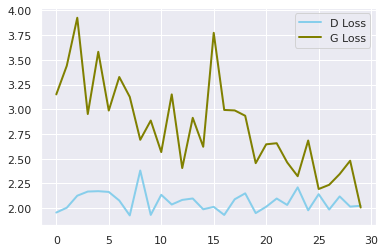

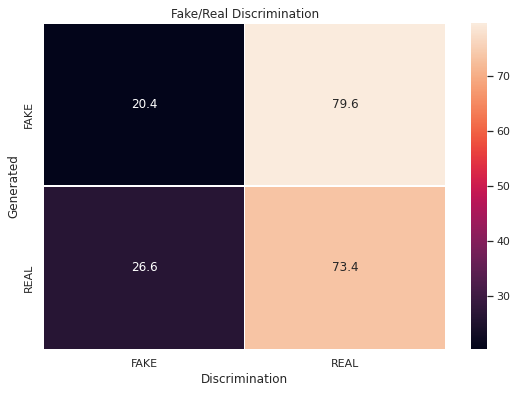

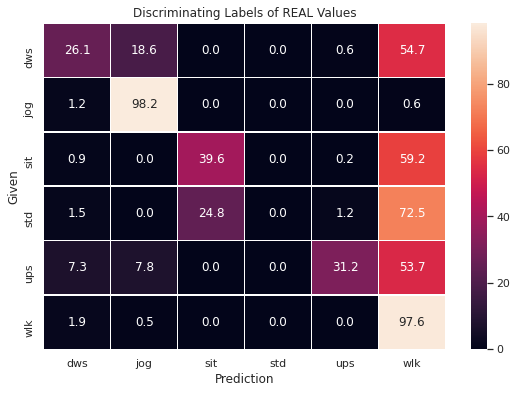

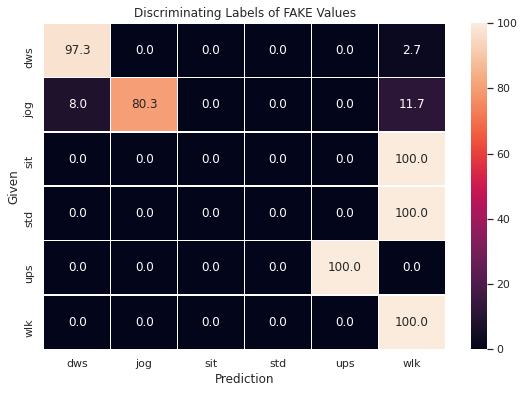

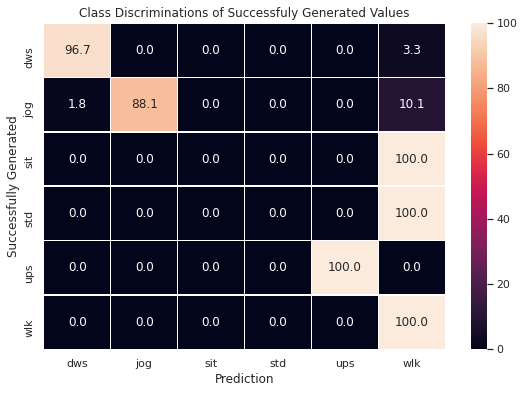

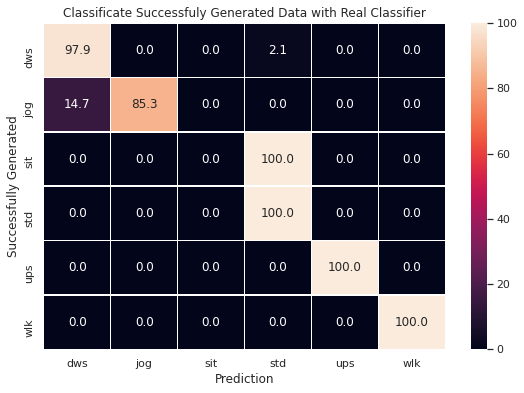

In [577]:
after_training(acgan_4, normalize="true")

## ACGAN 5

Its time to 1D CNN and AVG Pooling

In [402]:
class AcGan_5(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(600)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Reshape((100, 6))(y)
        y = Conv1D(filters=36, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=42, kernel_size=3, input_shape=(self.data_shape))(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)
        y = AveragePooling1D(pool_size=2)(y)
        y = Flatten()(y)
        y = Dropout(0.3)(y)
        y = Dense(120)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.3)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [403]:
acgan_5 = AcGan_5(windows.num_classes, n_latents, seq.shape[-2:])
acgan_5.combined.summary()
acgan_5.generator.summary()
acgan_5.discriminator.summary()
acgan_5.train(seq, 30)

Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_179 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_180 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_91 (Model)                (None, 100, 6)       2285628     input_179[0][0]                  
                                                                 input_180[0][0]                  
__________________________________________________________________________________________________
model_92 (Model)                [(None, 1), (None, 6 248725      model_91[1][0]            

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 1.776; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 2.804]
Epoch 2/30
[Disc loss: 1.901; Disc acc: %100.0%, Cls acc: %31.2%] [G loss: 2.886]
Epoch 3/30
[Disc loss: 1.830; Disc acc: %100.0%, Cls acc: %43.8%] [G loss: 3.556]
Epoch 4/30
[Disc loss: 1.966; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 3.006]
Epoch 5/30
[Disc loss: 1.855; Disc acc: %100.0%, Cls acc: %43.8%] [G loss: 3.399]
Epoch 6/30
[Disc loss: 1.769; Disc acc: %100.0%, Cls acc: %42.2%] [G loss: 3.612]
Epoch 7/30
[Disc loss: 1.877; Disc acc: %100.0%, Cls acc: %42.2%] [G loss: 2.989]
Epoch 8/30
[Disc loss: 1.927; Disc acc: %100.0%, Cls acc: %43.8%] [G loss: 3.335]
Epoch 9/30
[Disc loss: 1.839; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 2.931]
Epoch 10/30
[Disc loss: 1.856; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 3.130]
Epoch 11/30
[Disc loss: 1.921; Disc acc: %100.0%, Cls acc: %34.4%] [G loss: 2.902]
Epoch 12/30
[Disc loss: 1.985; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.985]
Epoch 13/30
[Disc loss: 

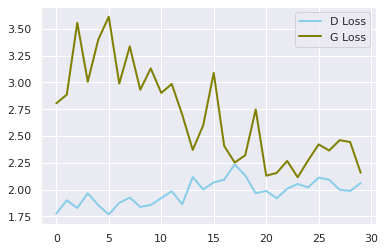

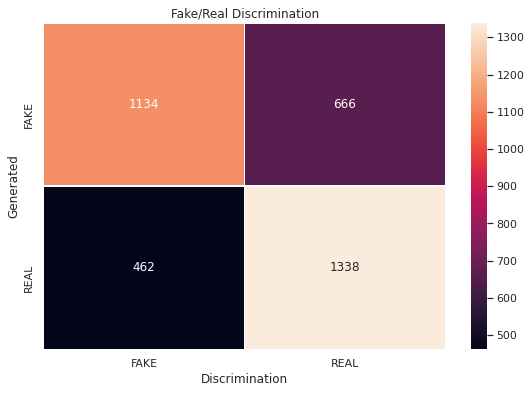

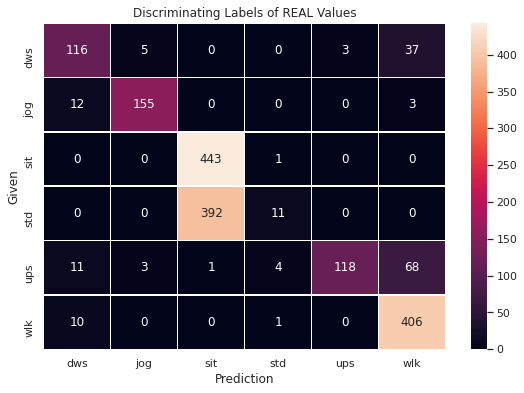

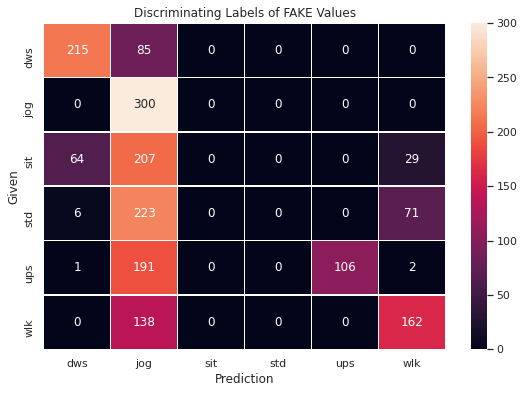

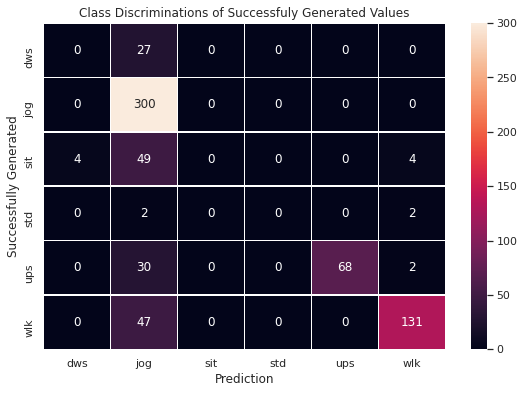

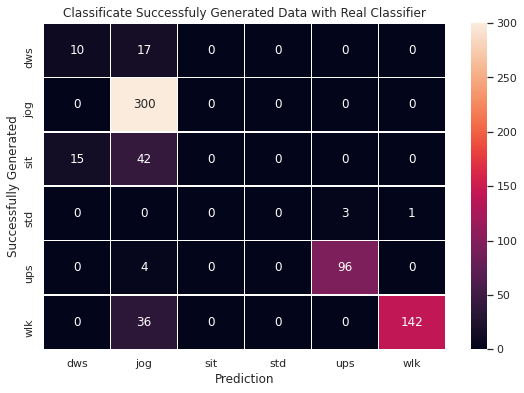

In [544]:
after_training(acgan_5)

## ACGAN 6

In [449]:
class AcGan_6(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=32, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = ZeroPadding1D()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        features = Flatten()(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [450]:
acgan_6 = AcGan_6(windows.num_classes, n_latents, seq.shape[-2:])
acgan_6.combined.summary()
acgan_6.generator.summary()
acgan_6.discriminator.summary()
acgan_6.train(seq, 30)

Model: "model_105"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_207 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_208 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_103 (Model)               (None, 100, 6)       3963136     input_207[0][0]                  
                                                                 input_208[0][0]                  
__________________________________________________________________________________________________
model_104 (Model)               [(None, 1), (None, 6 23463       model_103[1][0]          

[Disc loss: 1.885; Disc acc: %100.0%, Cls acc: %31.2%] [G loss: 1.396]
Epoch 14/30
[Disc loss: 1.993; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 1.612]
Epoch 15/30
[Disc loss: 2.088; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 1.749]
Epoch 16/30
[Disc loss: 2.099; Disc acc: %100.0%, Cls acc: %34.4%] [G loss: 1.652]
Epoch 17/30
[Disc loss: 1.978; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 1.361]
Epoch 18/30
[Disc loss: 2.275; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 1.882]
Epoch 19/30
[Disc loss: 2.139; Disc acc: %100.0%, Cls acc: %48.4%] [G loss: 1.963]
Epoch 20/30
[Disc loss: 2.282; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 1.772]
Epoch 21/30
[Disc loss: 2.280; Disc acc: %100.0%, Cls acc: %34.4%] [G loss: 1.873]
Epoch 22/30
[Disc loss: 2.245; Disc acc: %100.0%, Cls acc: %40.6%] [G loss: 1.874]
Epoch 23/30
[Disc loss: 2.123; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 1.975]
Epoch 24/30
[Disc loss: 2.092; Disc acc: %100.0%, Cls acc: %46.9%] [G loss: 1.773]
Epoch 25/30
[Dis

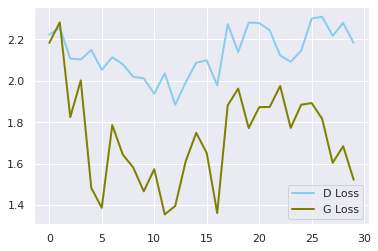

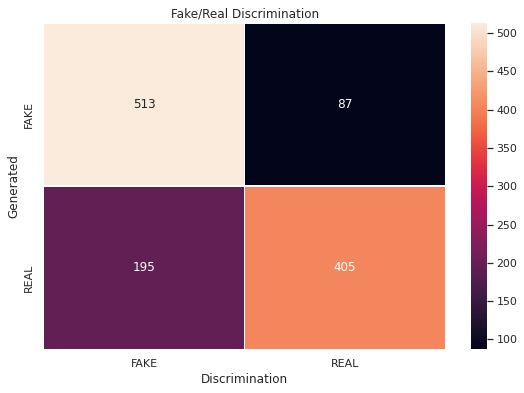

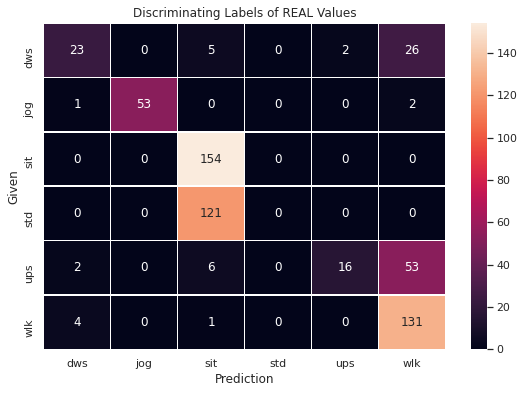

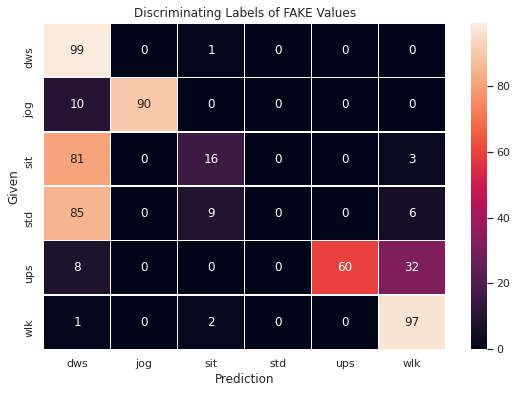

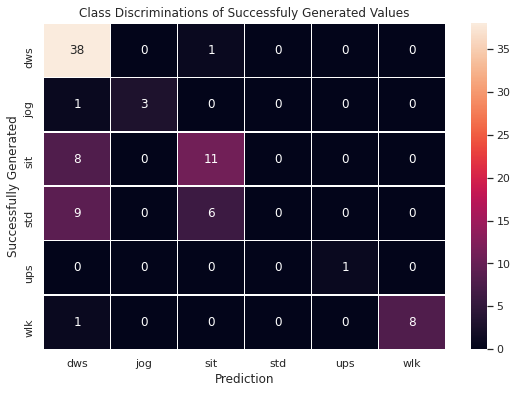

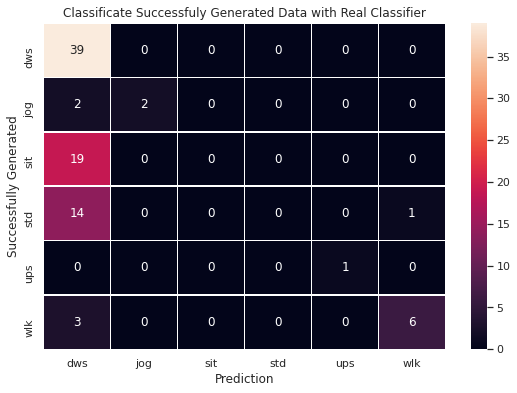

In [451]:
after_training(acgan_6)

## ACGAN 7

In [455]:
class AcGan_7(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=64, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = ZeroPadding1D()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        features = Flatten()(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [456]:
acgan_7 = AcGan_7(windows.num_classes, n_latents, seq.shape[-2:])
acgan_7.combined.summary()
acgan_7.generator.summary()
acgan_7.discriminator.summary()
acgan_7.train(seq, 30)

Model: "model_108"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_214 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_215 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_106 (Model)               (None, 100, 6)       4333176     input_214[0][0]                  
                                                                 input_215[0][0]                  
__________________________________________________________________________________________________
model_107 (Model)               [(None, 1), (None, 6 46919       model_106[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 2.043; Disc acc: %100.0%, Cls acc: %42.2%] [G loss: 3.544]
Epoch 2/30
[Disc loss: 2.005; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 3.223]
Epoch 3/30
[Disc loss: 2.270; Disc acc: %100.0%, Cls acc: %29.7%] [G loss: 2.861]
Epoch 4/30
[Disc loss: 2.205; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.656]
Epoch 5/30
[Disc loss: 2.213; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.453]
Epoch 6/30
[Disc loss: 2.440; Disc acc: %100.0%, Cls acc: %32.8%] [G loss: 2.632]
Epoch 7/30
[Disc loss: 2.416; Disc acc: %100.0%, Cls acc: %32.8%] [G loss: 2.386]
Epoch 8/30
[Disc loss: 2.196; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 2.739]
Epoch 9/30
[Disc loss: 2.330; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 2.917]
Epoch 10/30
[Disc loss: 2.220; Disc acc: %100.0%, Cls acc: %37.5%] [G loss: 2.696]
Epoch 11/30
[Disc loss: 2.342; Disc acc: %100.0%, Cls acc: %35.9%] [G loss: 2.244]
Epoch 12/30
[Disc loss: 2.415; Disc acc: %100.0%, Cls acc: %39.1%] [G loss: 2.258]
Epoch 13/30
[Disc loss: 

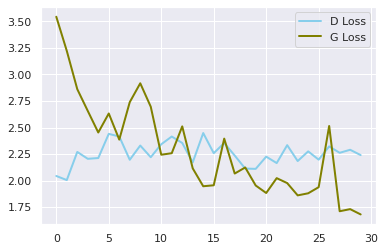

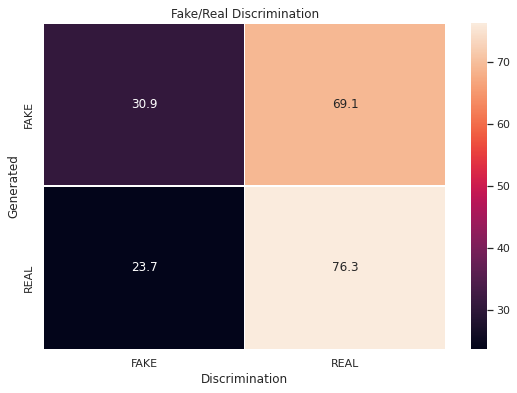

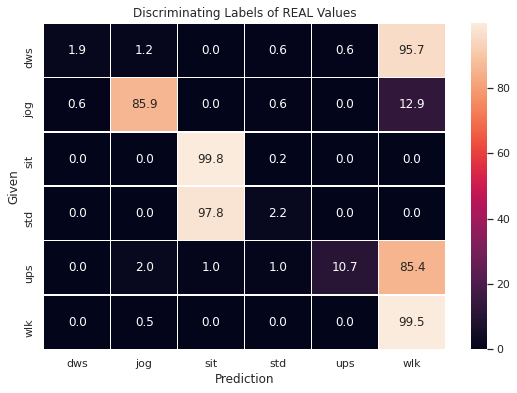

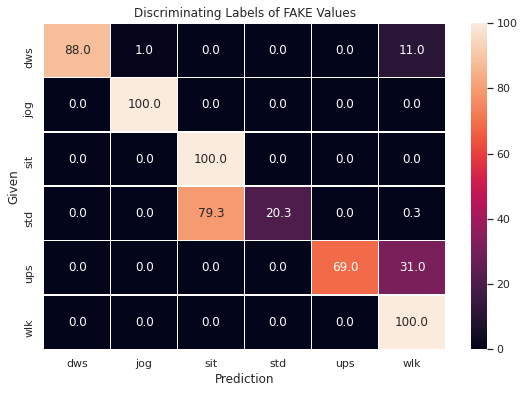

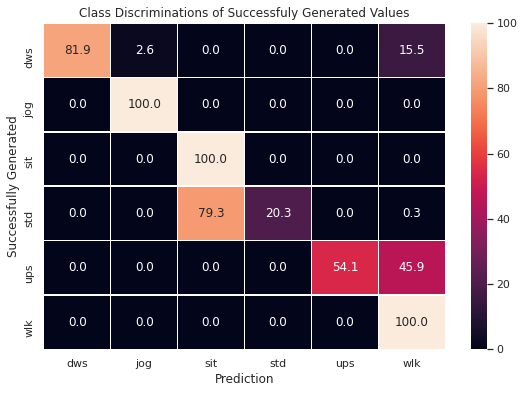

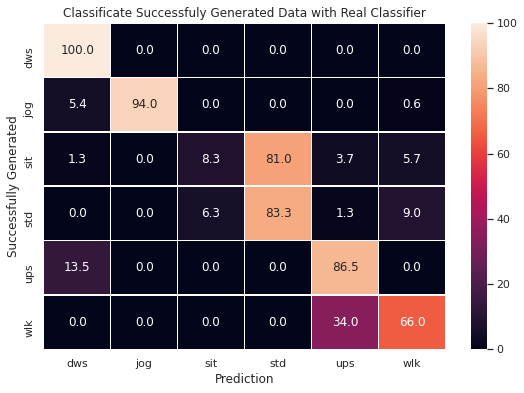

In [579]:
after_training(acgan_7, normalize="true")

## ACGAN 8

In [464]:
class AcGan_8(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=64, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = ZeroPadding1D()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = ZeroPadding1D()(y)
        y = Dropout(0.25)(y)
        y = Flatten()(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.5)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [465]:
acgan_8 = AcGan_8(windows.num_classes, n_latents, seq.shape[-2:])
acgan_8.combined.summary()
acgan_8.generator.summary()
acgan_8.discriminator.summary()
acgan_8.train(seq, 50)

Model: "model_111"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_219 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_220 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_109 (Model)               (None, 100, 6)       4333176     input_219[0][0]                  
                                                                 input_220[0][0]                  
__________________________________________________________________________________________________
model_110 (Model)               [(None, 1), (None, 6 2011399     model_109[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 1.951; acc?: %37.5%] [G loss: 3.598]
Epoch 2/50
[Disc loss: 1.763; acc?: %42.2%] [G loss: 3.427]
Epoch 3/50
[Disc loss: 1.686; acc?: %45.3%] [G loss: 2.997]
Epoch 4/50
[Disc loss: 1.787; acc?: %45.3%] [G loss: 3.488]
Epoch 5/50
[Disc loss: 1.678; acc?: %51.6%] [G loss: 3.248]
Epoch 6/50
[Disc loss: 1.842; acc?: %37.5%] [G loss: 3.529]
Epoch 7/50
[Disc loss: 1.652; acc?: %45.3%] [G loss: 3.632]
Epoch 8/50
[Disc loss: 1.759; acc?: %43.8%] [G loss: 3.559]
Epoch 9/50
[Disc loss: 1.705; acc?: %48.4%] [G loss: 3.462]
Epoch 10/50
[Disc loss: 1.599; acc?: %45.3%] [G loss: 3.373]
Epoch 11/50
[Disc loss: 1.616; acc?: %42.2%] [G loss: 3.609]
Epoch 12/50
[Disc loss: 1.618; acc?: %42.2%] [G loss: 3.131]
Epoch 13/50
[Disc loss: 1.873; acc?: %40.6%] [G loss: 3.619]
Epoch 14/50
[Disc loss: 1.620; acc?: %43.8%] [G loss: 3.567]
Epoch 15/50
[Disc loss: 1.608; acc?: %50.0%] [G loss: 3.507]
Epoch 16/50
[Disc loss: 1.594; acc?: %45.3%] [G loss: 3.567]
Epoch 17/50
[Disc loss: 1.673; acc?: %40.6%]

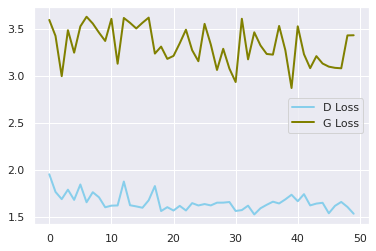

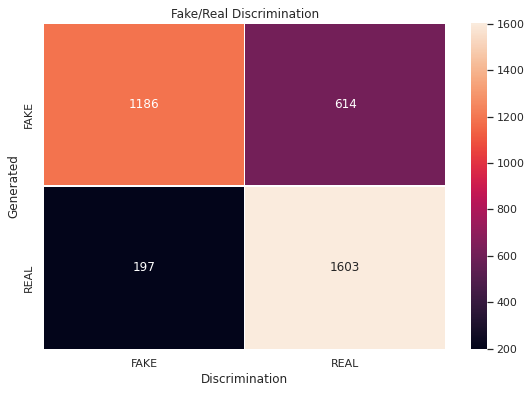

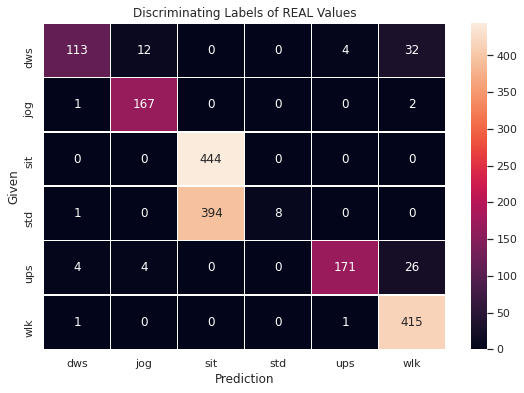

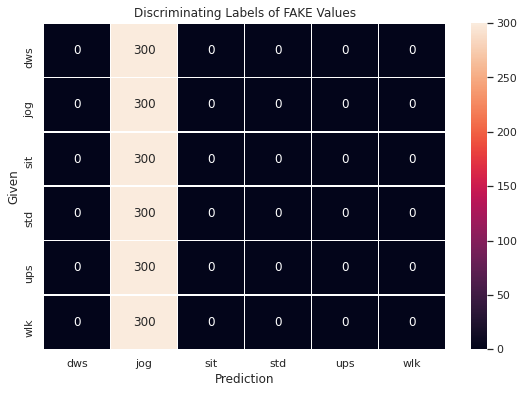

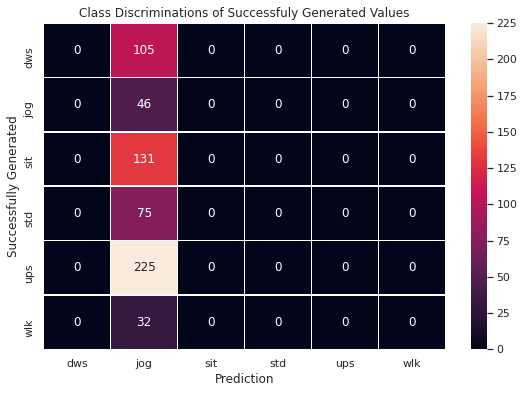

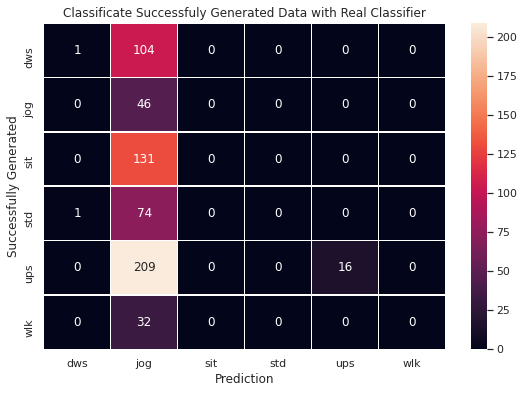

In [466]:
after_training(acgan_8)

## ACGAN 9

In [468]:
class AcGan_9(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=128, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=64, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = ZeroPadding1D()(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = ZeroPadding1D()(y)
        y = Dropout(0.25)(y)
        y = Flatten()(y)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.5)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [470]:
acgan_9 = AcGan_9(windows.num_classes, n_latents, seq.shape[-2:])
acgan_9.combined.summary()
acgan_9.generator.summary()
acgan_9.discriminator.summary()
acgan_9.train(seq, 50)

Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_229 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_230 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_115 (Model)               (None, 100, 6)       8556240     input_229[0][0]                  
                                                                 input_230[0][0]                  
__________________________________________________________________________________________________
model_116 (Model)               [(None, 1), (None, 6 2011399     model_115[1][0]          

[Disc loss: 1.819; acc?: %42.2%] [G loss: 3.588]
Epoch 2/50
[Disc loss: 1.764; acc?: %45.3%] [G loss: 3.497]
Epoch 3/50
[Disc loss: 1.688; acc?: %50.0%] [G loss: 3.032]
Epoch 4/50
[Disc loss: 1.632; acc?: %43.8%] [G loss: 3.391]
Epoch 5/50
[Disc loss: 1.733; acc?: %50.0%] [G loss: 3.438]
Epoch 6/50
[Disc loss: 1.703; acc?: %45.3%] [G loss: 3.332]
Epoch 7/50
[Disc loss: 1.807; acc?: %43.8%] [G loss: 3.258]
Epoch 8/50
[Disc loss: 1.737; acc?: %51.6%] [G loss: 3.855]
Epoch 9/50
[Disc loss: 1.790; acc?: %39.1%] [G loss: 3.555]
Epoch 10/50
[Disc loss: 1.706; acc?: %46.9%] [G loss: 3.473]
Epoch 11/50
[Disc loss: 1.709; acc?: %48.4%] [G loss: 3.275]
Epoch 12/50
[Disc loss: 1.723; acc?: %48.4%] [G loss: 3.289]
Epoch 13/50
[Disc loss: 1.611; acc?: %46.9%] [G loss: 3.126]
Epoch 14/50
[Disc loss: 1.858; acc?: %46.9%] [G loss: 3.453]
Epoch 15/50
[Disc loss: 1.597; acc?: %48.4%] [G loss: 2.864]
Epoch 16/50
[Disc loss: 1.721; acc?: %42.2%] [G loss: 3.456]
Epoch 17/50
[Disc loss: 1.700; acc?: %50.0%]

[]


AttributeError: 'list' object has no attribute 'ar'

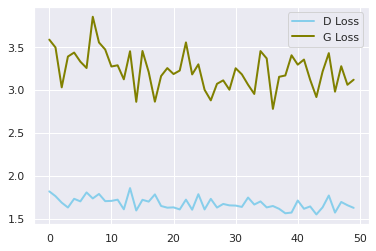

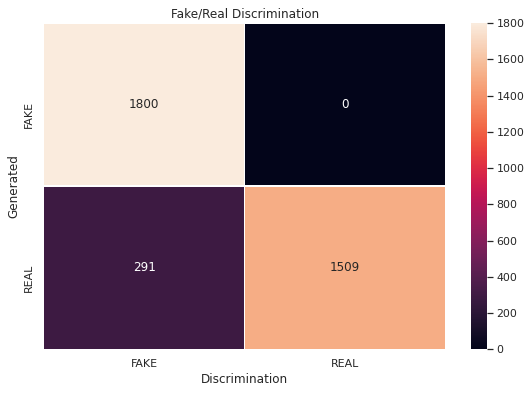

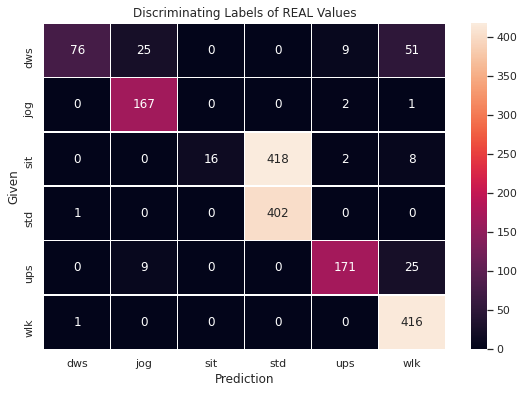

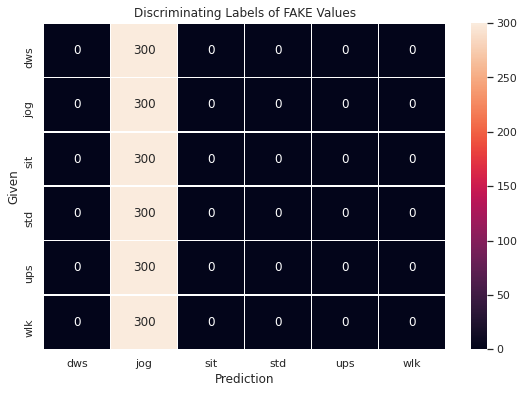

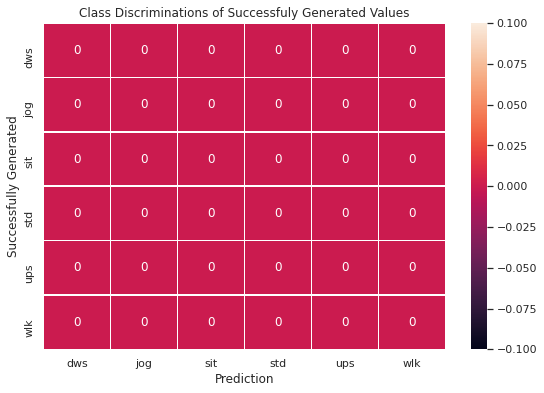

In [498]:
after_training(acgan_9)

In [508]:
class AcGan_10(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=16, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=64, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        features = Flatten()(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [509]:
acgan_10 = AcGan_10(windows.num_classes, n_latents, seq.shape[-2:])
acgan_10.combined.summary()
acgan_10.generator.summary()
acgan_10.discriminator.summary()
acgan_10.train(seq, 50)

Model: "model_123"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_241 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_242 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_121 (Model)               (None, 100, 6)       2414792     input_241[0][0]                  
                                                                 input_242[0][0]                  
__________________________________________________________________________________________________
model_122 (Model)               [(None, 1), (None, 6 46023       model_121[1][0]          

[Disc loss: 2.008; acc?: %31.2%] [G loss: 3.814]
Epoch 2/50
[Disc loss: 2.079; acc?: %32.8%] [G loss: 8.035]
Epoch 3/50
[Disc loss: 2.237; acc?: %32.8%] [G loss: 3.388]
Epoch 4/50
[Disc loss: 2.686; acc?: %42.2%] [G loss: 3.745]
Epoch 5/50
[Disc loss: 2.073; acc?: %46.9%] [G loss: 3.017]
Epoch 6/50
[Disc loss: 2.121; acc?: %39.1%] [G loss: 3.982]
Epoch 7/50
[Disc loss: 2.297; acc?: %32.8%] [G loss: 2.665]
Epoch 8/50
[Disc loss: 2.295; acc?: %40.6%] [G loss: 5.023]
Epoch 9/50
[Disc loss: 2.225; acc?: %40.6%] [G loss: 2.549]
Epoch 10/50
[Disc loss: 2.141; acc?: %48.4%] [G loss: 2.550]
Epoch 11/50
[Disc loss: 2.297; acc?: %45.3%] [G loss: 2.447]
Epoch 12/50
[Disc loss: 2.260; acc?: %32.8%] [G loss: 2.504]
Epoch 13/50
[Disc loss: 2.133; acc?: %43.8%] [G loss: 4.286]
Epoch 14/50
[Disc loss: 2.193; acc?: %43.8%] [G loss: 1.975]
Epoch 15/50
[Disc loss: 2.088; acc?: %42.2%] [G loss: 2.059]
Epoch 16/50
[Disc loss: 2.270; acc?: %34.4%] [G loss: 3.430]
Epoch 17/50
[Disc loss: 2.211; acc?: %37.5%]

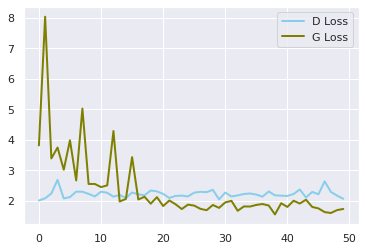

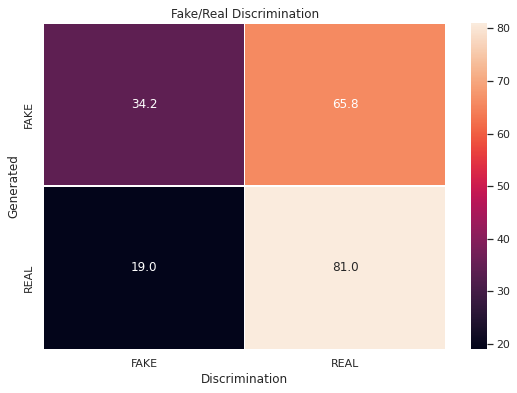

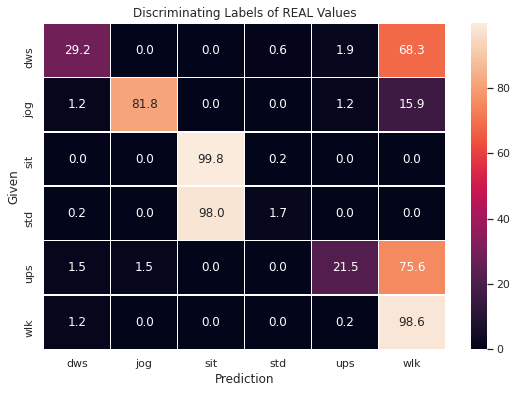

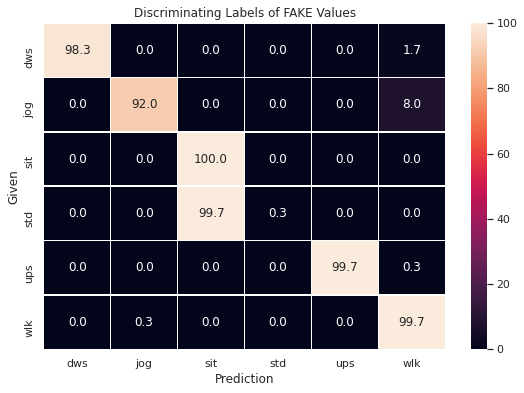

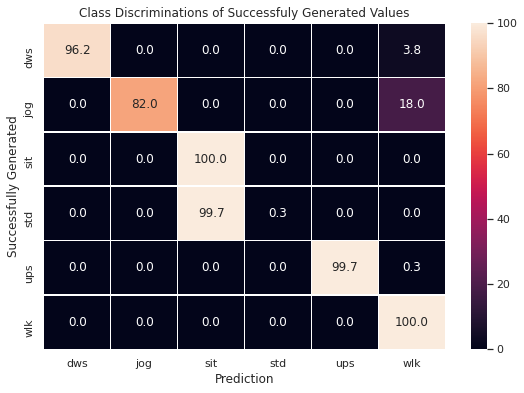

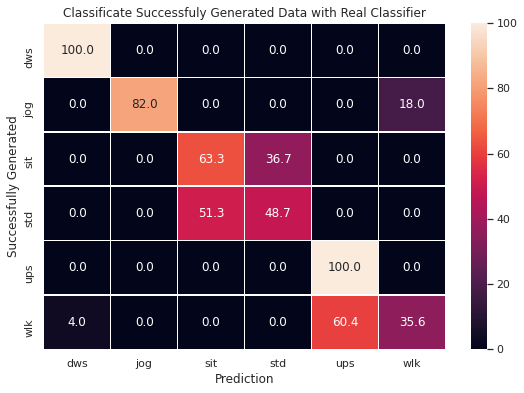

In [578]:
after_training(acgan_10, normalize="true")

## ACGAN 11

In [514]:
class AcGan_11(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=16, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=64, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.1)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [515]:
acgan_11 = AcGan_11(windows.num_classes, n_latents, seq.shape[-2:])
acgan_11.combined.summary()
acgan_11.generator.summary()
acgan_11.discriminator.summary()
acgan_11.train(seq, 50)

Model: "model_126"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_246 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_247 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_124 (Model)               (None, 100, 6)       2414792     input_246[0][0]                  
                                                                 input_247[0][0]                  
__________________________________________________________________________________________________
model_125 (Model)               [(None, 1), (None, 6 3848423     model_124[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 1.781; acc?: %51.6%] [G loss: 3.254]
Epoch 2/50
[Disc loss: 1.683; acc?: %39.1%] [G loss: 3.367]
Epoch 3/50
[Disc loss: 1.622; acc?: %43.8%] [G loss: 3.512]
Epoch 4/50
[Disc loss: 1.600; acc?: %51.6%] [G loss: 3.481]
Epoch 5/50
[Disc loss: 1.636; acc?: %45.3%] [G loss: 3.521]
Epoch 6/50
[Disc loss: 1.550; acc?: %46.9%] [G loss: 3.146]
Epoch 7/50
[Disc loss: 1.646; acc?: %50.0%] [G loss: 3.824]
Epoch 8/50
[Disc loss: 1.687; acc?: %46.9%] [G loss: 3.800]
Epoch 9/50
[Disc loss: 1.603; acc?: %42.2%] [G loss: 3.338]
Epoch 10/50
[Disc loss: 1.745; acc?: %46.9%] [G loss: 3.265]
Epoch 11/50
[Disc loss: 1.608; acc?: %43.8%] [G loss: 3.169]
Epoch 12/50
[Disc loss: 1.675; acc?: %48.4%] [G loss: 3.569]
Epoch 13/50
[Disc loss: 1.813; acc?: %40.6%] [G loss: 3.266]
Epoch 14/50
[Disc loss: 1.596; acc?: %43.8%] [G loss: 3.358]
Epoch 15/50
[Disc loss: 1.513; acc?: %45.3%] [G loss: 3.436]
Epoch 16/50
[Disc loss: 1.564; acc?: %48.4%] [G loss: 3.218]
Epoch 17/50
[Disc loss: 1.624; acc?: %43.8%]

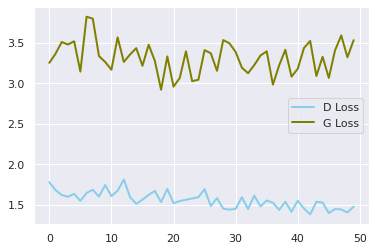

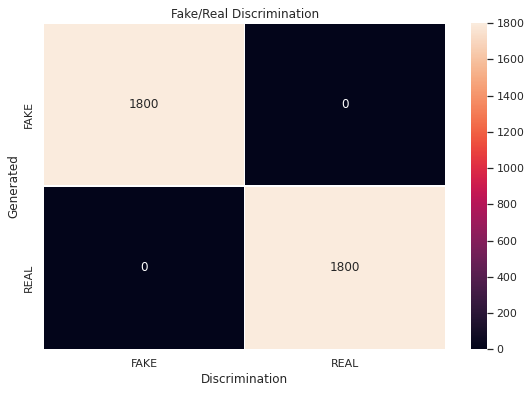

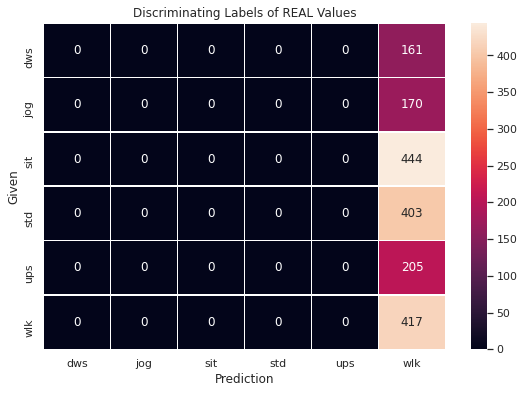

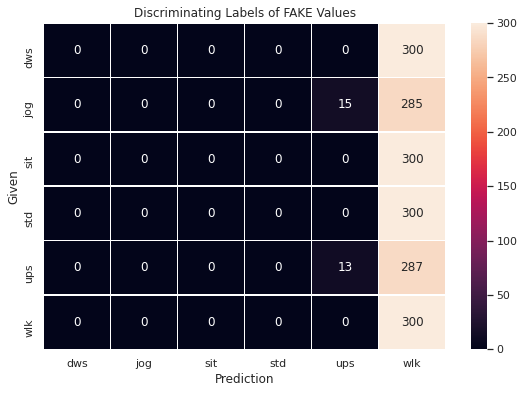

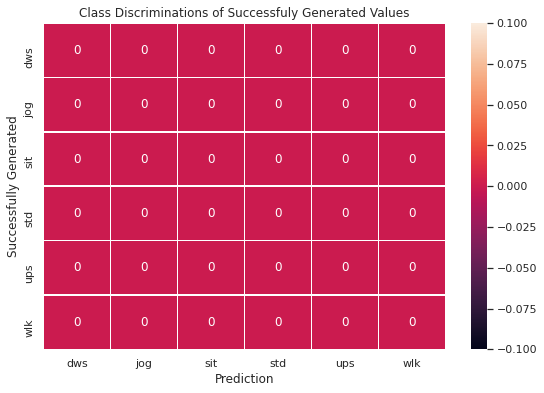

In [518]:
after_training(acgan_11)

## ACGAN 12

In [519]:
class AcGan_12(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=128, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=16, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=128, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        features = Flatten()(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [520]:
acgan_12 = AcGan_12(windows.num_classes, n_latents, seq.shape[-2:])
acgan_12.combined.summary()
acgan_12.generator.summary()
acgan_12.discriminator.summary()
acgan_12.train(seq, 50)

Model: "model_129"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_251 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_252 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_127 (Model)               (None, 100, 6)       2436392     input_251[0][0]                  
                                                                 input_252[0][0]                  
__________________________________________________________________________________________________
model_128 (Model)               [(None, 1), (None, 6 92039       model_127[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 2.003; acc?: %35.9%] [G loss: 3.787]
Epoch 2/50
[Disc loss: 2.095; acc?: %39.1%] [G loss: 3.246]
Epoch 3/50
[Disc loss: 2.110; acc?: %39.1%] [G loss: 3.589]
Epoch 4/50
[Disc loss: 2.102; acc?: %37.5%] [G loss: 3.924]
Epoch 5/50
[Disc loss: 2.299; acc?: %37.5%] [G loss: 2.545]
Epoch 6/50
[Disc loss: 2.420; acc?: %37.5%] [G loss: 3.324]
Epoch 7/50
[Disc loss: 2.204; acc?: %32.8%] [G loss: 2.771]
Epoch 8/50
[Disc loss: 2.727; acc?: %40.6%] [G loss: 2.391]
Epoch 9/50
[Disc loss: 2.378; acc?: %37.5%] [G loss: 3.214]
Epoch 10/50
[Disc loss: 2.307; acc?: %31.2%] [G loss: 2.800]
Epoch 11/50
[Disc loss: 2.284; acc?: %45.3%] [G loss: 2.344]
Epoch 12/50
[Disc loss: 2.593; acc?: %40.6%] [G loss: 2.279]
Epoch 13/50
[Disc loss: 2.330; acc?: %32.8%] [G loss: 2.341]
Epoch 14/50
[Disc loss: 2.429; acc?: %39.1%] [G loss: 2.174]
Epoch 15/50
[Disc loss: 2.306; acc?: %40.6%] [G loss: 2.001]
Epoch 16/50
[Disc loss: 2.555; acc?: %43.8%] [G loss: 2.366]
Epoch 17/50
[Disc loss: 2.163; acc?: %42.2%]

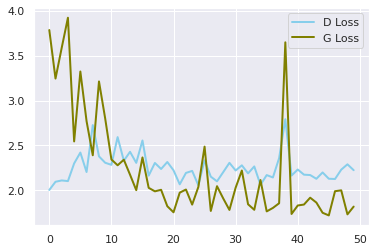

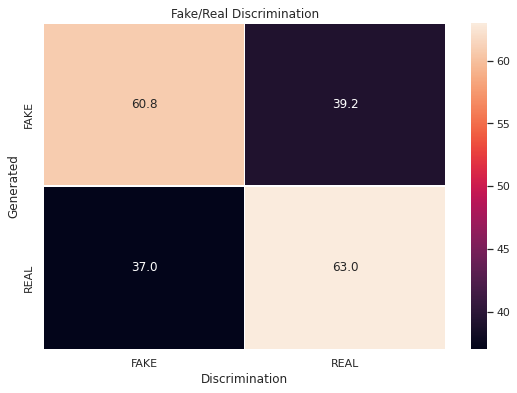

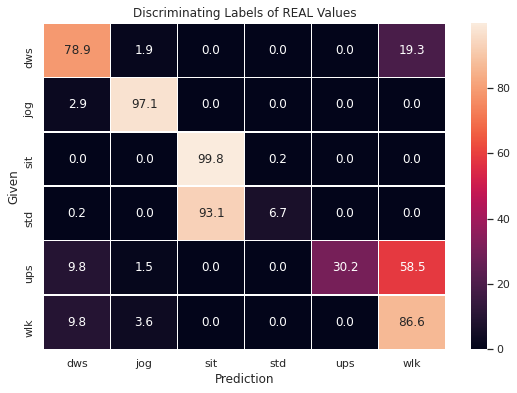

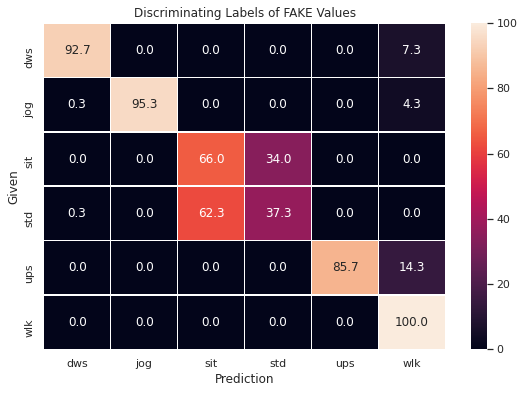

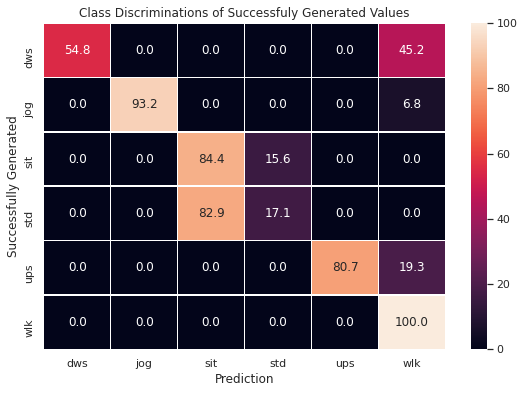

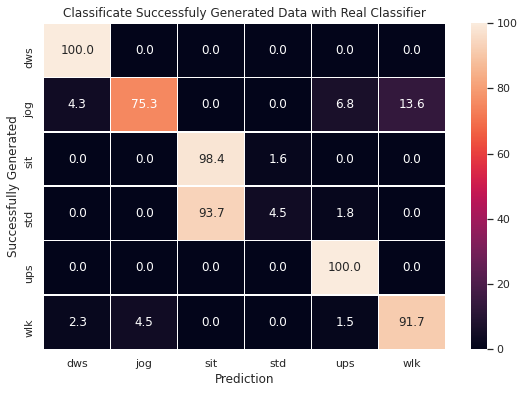

In [574]:
after_training(acgan_12, normalize="true")

## ACGAN 13

In [522]:
class AcGan_13(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=128, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=256, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.2)(y)
        features = Flatten()(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [523]:
acgan_13 = AcGan_13(windows.num_classes, n_latents, seq.shape[-2:])
acgan_13.combined.summary()
acgan_13.generator.summary()
acgan_13.discriminator.summary()
acgan_13.train(seq, 50)

Model: "model_132"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_256 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_257 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_130 (Model)               (None, 100, 6)       4359544     input_256[0][0]                  
                                                                 input_257[0][0]                  
__________________________________________________________________________________________________
model_131 (Model)               [(None, 1), (None, 6 184071      model_130[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 2.167; acc?: %31.2%] [G loss: 3.888]
Epoch 2/50
[Disc loss: 2.094; acc?: %31.2%] [G loss: 3.127]
Epoch 3/50
[Disc loss: 2.059; acc?: %31.2%] [G loss: 3.106]
Epoch 4/50
[Disc loss: 2.087; acc?: %32.8%] [G loss: 3.319]
Epoch 5/50
[Disc loss: 1.995; acc?: %32.8%] [G loss: 4.004]
Epoch 6/50
[Disc loss: 2.142; acc?: %39.1%] [G loss: 3.252]
Epoch 7/50
[Disc loss: 2.129; acc?: %37.5%] [G loss: 3.593]
Epoch 8/50
[Disc loss: 2.152; acc?: %37.5%] [G loss: 3.128]
Epoch 9/50
[Disc loss: 2.389; acc?: %34.4%] [G loss: 2.778]
Epoch 10/50
[Disc loss: 2.254; acc?: %32.8%] [G loss: 2.778]
Epoch 11/50
[Disc loss: 2.315; acc?: %40.6%] [G loss: 2.896]
Epoch 12/50
[Disc loss: 2.513; acc?: %42.2%] [G loss: 2.541]
Epoch 13/50
[Disc loss: 2.343; acc?: %34.4%] [G loss: 2.390]
Epoch 14/50
[Disc loss: 2.361; acc?: %32.8%] [G loss: 2.670]
Epoch 15/50
[Disc loss: 2.214; acc?: %42.2%] [G loss: 2.230]
Epoch 16/50
[Disc loss: 2.321; acc?: %46.9%] [G loss: 2.330]
Epoch 17/50
[Disc loss: 2.322; acc?: %32.8%]

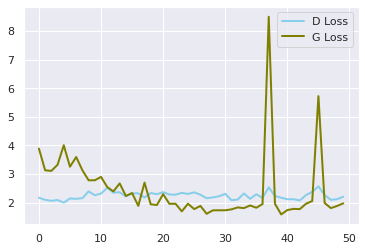

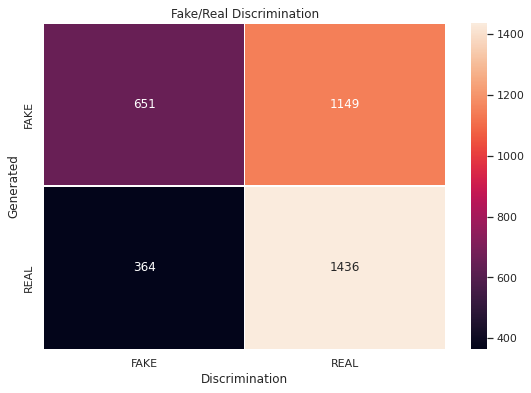

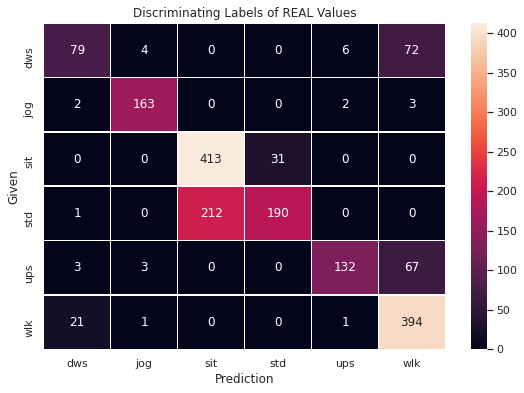

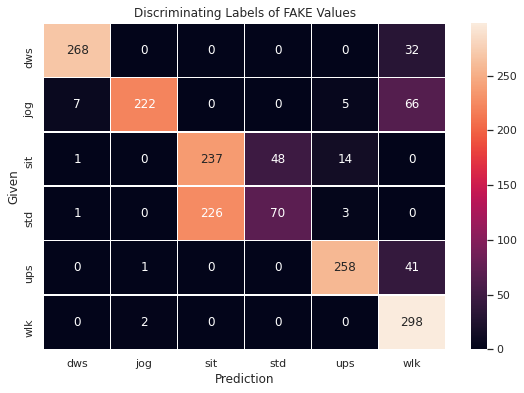

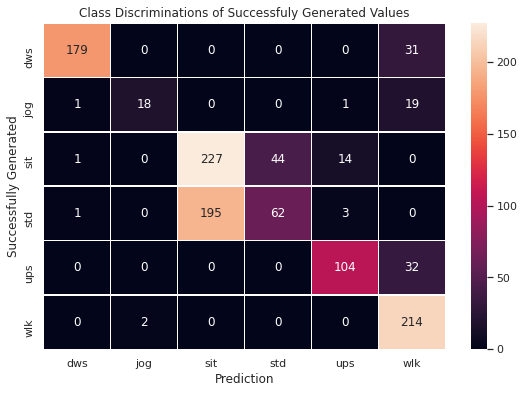

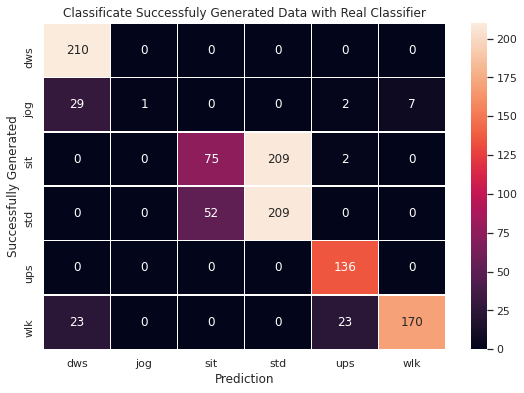

In [524]:
after_training(acgan_13)

## ACGAN 14

In [525]:
class AcGan_14(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=128, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=32, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.2)(y)
        y = Flatten()(y)
        y = Dense(100)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.2)(y)
        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [526]:
acgan_14 = AcGan_14(windows.num_classes, n_latents, seq.shape[-2:])
acgan_14.combined.summary()
acgan_14.generator.summary()
acgan_14.discriminator.summary()
acgan_14.train(seq, 50)

Model: "model_135"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_261 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_262 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_133 (Model)               (None, 100, 6)       4359544     input_261[0][0]                  
                                                                 input_262[0][0]                  
__________________________________________________________________________________________________
model_134 (Model)               [(None, 1), (None, 6 321815      model_133[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 1.951; acc?: %34.4%] [G loss: 2.572]
Epoch 2/50
[Disc loss: 1.898; acc?: %40.6%] [G loss: 2.760]
Epoch 3/50
[Disc loss: 1.678; acc?: %43.8%] [G loss: 3.589]
Epoch 4/50
[Disc loss: 1.706; acc?: %53.1%] [G loss: 3.236]
Epoch 5/50
[Disc loss: 1.745; acc?: %42.2%] [G loss: 3.495]
Epoch 6/50
[Disc loss: 1.709; acc?: %43.8%] [G loss: 3.648]
Epoch 7/50
[Disc loss: 1.678; acc?: %46.9%] [G loss: 3.946]
Epoch 8/50
[Disc loss: 1.745; acc?: %40.6%] [G loss: 3.446]
Epoch 9/50
[Disc loss: 1.641; acc?: %46.9%] [G loss: 2.978]
Epoch 10/50
[Disc loss: 1.703; acc?: %40.6%] [G loss: 3.231]
Epoch 11/50
[Disc loss: 1.702; acc?: %45.3%] [G loss: 3.134]
Epoch 12/50
[Disc loss: 1.692; acc?: %43.8%] [G loss: 3.106]
Epoch 13/50
[Disc loss: 1.802; acc?: %45.3%] [G loss: 3.593]
Epoch 14/50
[Disc loss: 1.691; acc?: %45.3%] [G loss: 3.338]
Epoch 15/50
[Disc loss: 1.761; acc?: %45.3%] [G loss: 3.498]
Epoch 16/50
[Disc loss: 1.612; acc?: %48.4%] [G loss: 2.997]
Epoch 17/50
[Disc loss: 1.632; acc?: %45.3%]

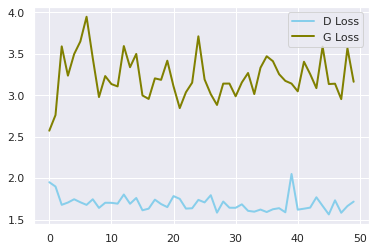

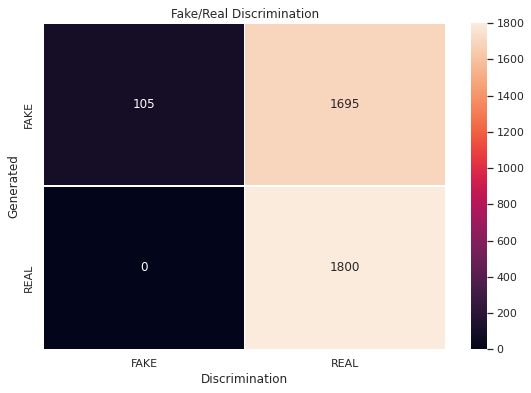

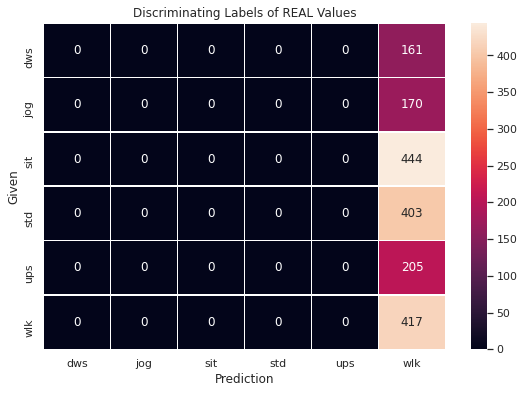

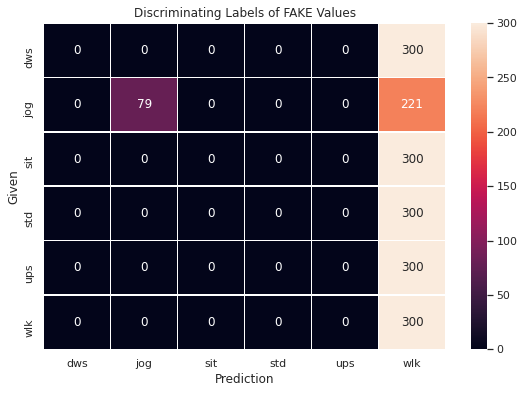

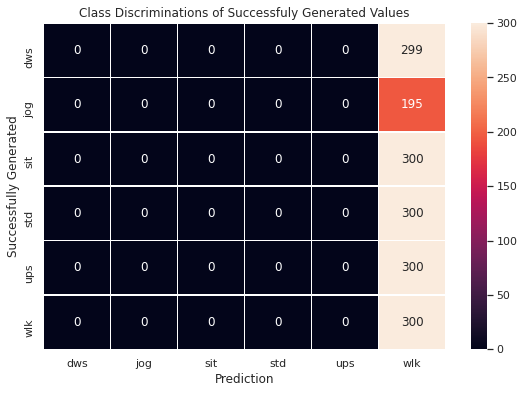

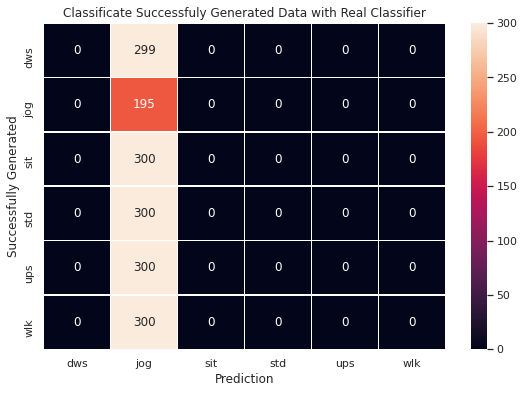

In [527]:
after_training(acgan_14)

## ACGAN 15

In [530]:
class AcGan_15(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=16, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=16, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.2)(y)
        y = Flatten()(y)
        y = Dense(20)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.2)(y)
        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [531]:
acgan_15 = AcGan_15(windows.num_classes, n_latents, seq.shape[-2:])
acgan_15.combined.summary()
acgan_15.generator.summary()
acgan_15.discriminator.summary()
acgan_15.train(seq, 50)

Model: "model_141"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_271 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_272 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_139 (Model)               (None, 100, 6)       2414792     input_271[0][0]                  
                                                                 input_272[0][0]                  
__________________________________________________________________________________________________
model_140 (Model)               [(None, 1), (None, 6 32551       model_139[1][0]          

[Disc loss: 2.199; acc?: %42.2%] [G loss: 2.452]
Epoch 2/50
[Disc loss: 2.085; acc?: %43.8%] [G loss: 2.346]
Epoch 3/50
[Disc loss: 1.973; acc?: %43.8%] [G loss: 2.421]
Epoch 4/50
[Disc loss: 1.909; acc?: %45.3%] [G loss: 2.439]
Epoch 5/50
[Disc loss: 1.945; acc?: %43.8%] [G loss: 2.537]
Epoch 6/50
[Disc loss: 1.889; acc?: %39.1%] [G loss: 2.656]
Epoch 7/50
[Disc loss: 2.005; acc?: %40.6%] [G loss: 2.855]
Epoch 8/50
[Disc loss: 1.909; acc?: %43.8%] [G loss: 2.547]
Epoch 9/50
[Disc loss: 1.917; acc?: %46.9%] [G loss: 3.007]
Epoch 10/50
[Disc loss: 1.978; acc?: %43.8%] [G loss: 2.595]
Epoch 11/50
[Disc loss: 1.959; acc?: %42.2%] [G loss: 3.188]
Epoch 12/50
[Disc loss: 1.882; acc?: %46.9%] [G loss: 2.657]
Epoch 13/50
[Disc loss: 2.078; acc?: %40.6%] [G loss: 3.500]
Epoch 14/50
[Disc loss: 1.879; acc?: %40.6%] [G loss: 2.678]
Epoch 15/50
[Disc loss: 1.861; acc?: %42.2%] [G loss: 2.617]
Epoch 16/50
[Disc loss: 1.893; acc?: %46.9%] [G loss: 3.083]
Epoch 17/50
[Disc loss: 1.937; acc?: %35.9%]

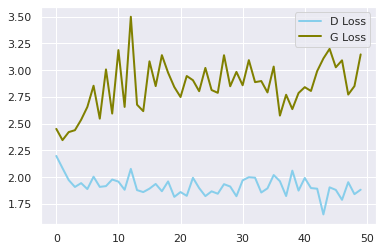

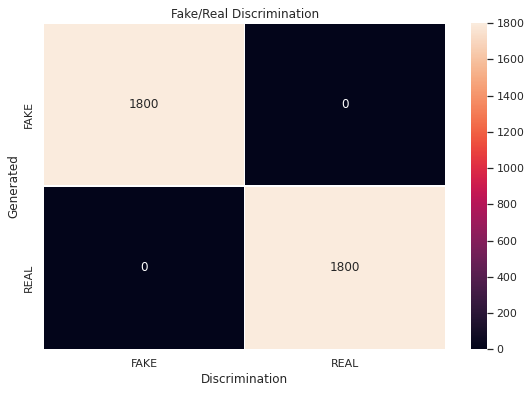

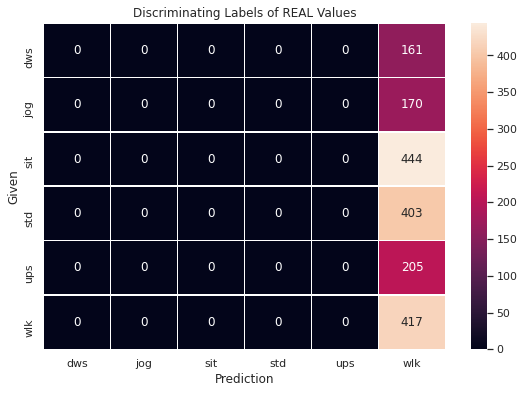

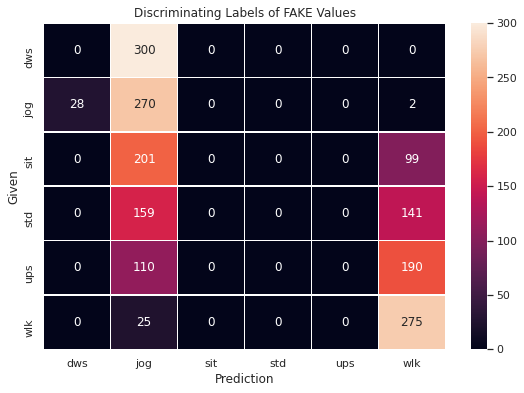

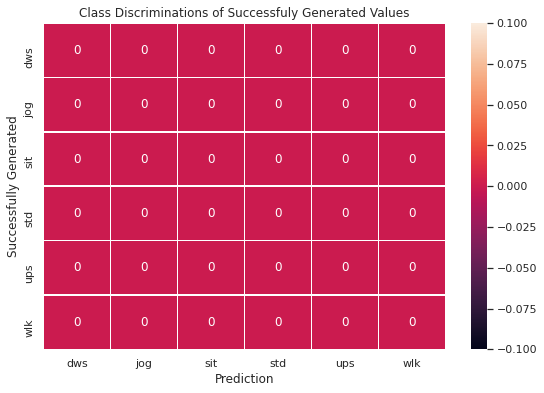

In [532]:
after_training(acgan_15)

## ACGAN 16

In [533]:
class AcGan_16(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(numpy.prod(self.data_shape))(x)
        y = Dropout(0.5)(y, training=True)
        y = Reshape(self.data_shape)(y)
        y = UpSampling1D()(y)
        y = Conv1D(filters=64, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = UpSampling1D()(y)
        y = Conv1D(filters=32, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = UpSampling1D()(y)
        y = Conv1D(filters=16, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = UpSampling1D()(y)
        y = Dropout(0.5)(y, training=True)
        y = Conv1D(filters=8, kernel_size=3, padding="same")(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Flatten()(y)
        y = Dense(numpy.prod(self.data_shape))(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=64, kernel_size=3, input_shape=(self.data_shape), padding="same")(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.25)(y)
        features = Flatten()(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [534]:
acgan_16 = AcGan_16(windows.num_classes, n_latents, seq.shape[-2:])
acgan_16.combined.summary()
acgan_16.generator.summary()
acgan_16.discriminator.summary()
acgan_16.train(seq, 50)

Model: "model_144"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_276 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_277 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_142 (Model)               (None, 100, 6)       8175216     input_276[0][0]                  
                                                                 input_277[0][0]                  
__________________________________________________________________________________________________
model_143 (Model)               [(None, 1), (None, 6 46023       model_142[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 2.036; acc?: %42.2%] [G loss: 2.722]
Epoch 2/50
[Disc loss: 2.192; acc?: %35.9%] [G loss: 4.228]
Epoch 3/50
[Disc loss: 2.080; acc?: %39.1%] [G loss: 2.924]
Epoch 4/50
[Disc loss: 2.218; acc?: %34.4%] [G loss: 3.263]
Epoch 5/50
[Disc loss: 2.141; acc?: %37.5%] [G loss: 2.693]
Epoch 6/50
[Disc loss: 2.145; acc?: %40.6%] [G loss: 3.544]
Epoch 7/50
[Disc loss: 2.256; acc?: %35.9%] [G loss: 2.622]
Epoch 8/50
[Disc loss: 2.115; acc?: %42.2%] [G loss: 2.426]
Epoch 9/50
[Disc loss: 2.196; acc?: %37.5%] [G loss: 2.550]
Epoch 10/50
[Disc loss: 2.662; acc?: %31.2%] [G loss: 2.964]
Epoch 11/50
[Disc loss: 2.412; acc?: %37.5%] [G loss: 2.774]
Epoch 12/50
[Disc loss: 2.129; acc?: %42.2%] [G loss: 2.500]
Epoch 13/50
[Disc loss: 2.174; acc?: %43.8%] [G loss: 2.640]
Epoch 14/50
[Disc loss: 2.225; acc?: %50.0%] [G loss: 2.370]
Epoch 15/50
[Disc loss: 2.294; acc?: %40.6%] [G loss: 2.942]
Epoch 16/50
[Disc loss: 2.283; acc?: %40.6%] [G loss: 2.156]
Epoch 17/50
[Disc loss: 2.225; acc?: %43.8%]

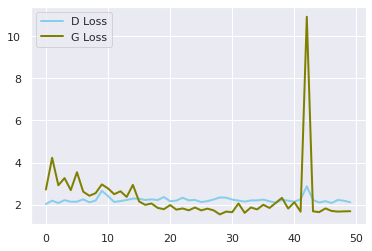

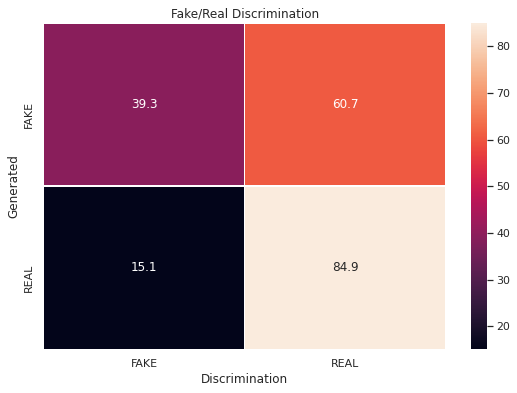

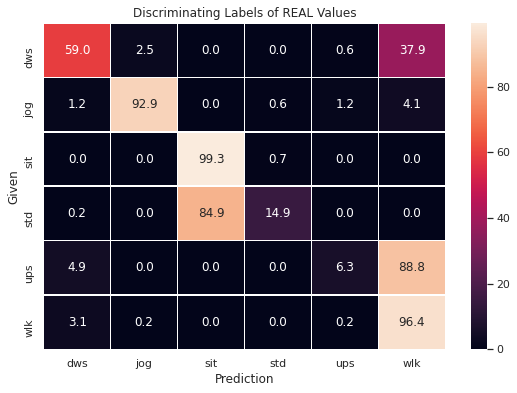

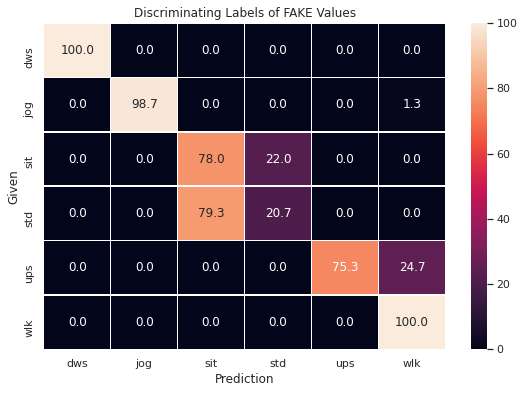

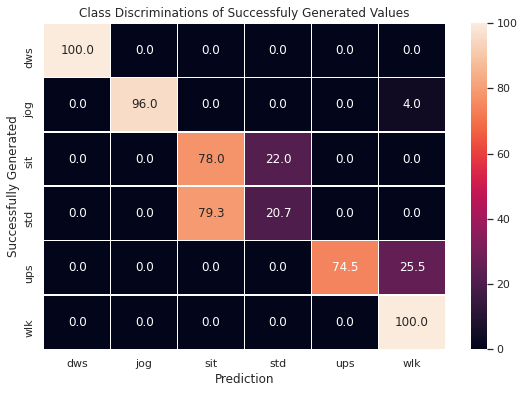

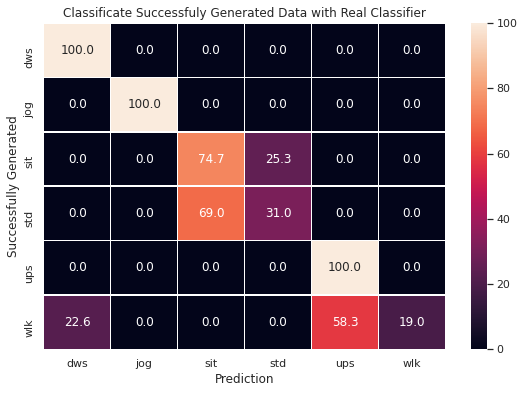

In [573]:
after_training(acgan_16, normalize="true")

## ACGAN 17

In [580]:
class AcGan_17(GAN):

    def __init__(self, num_classes, latent_size, data_shape):
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.data_shape = data_shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.combined = self.combine()
        
        GAN.__init__(self)
        
    def build_generator(self):
        latent = Input((self.latent_size,))
        label = Input((1,), dtype="int32")
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_size)(label))
        x = multiply([latent, label_embedding])
        y = Dense(400)(x)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(1000)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(1000)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(800)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(600)(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.5)(y, training=True)
        y = Dense(numpy.prod(self.data_shape), activation="tanh")(y)
        y = Reshape(self.data_shape)(y)
        
        return Model(inputs=[latent, label], outputs=y)

    def build_discriminator(self):
        
        data = Input(self.data_shape)
        y = Conv1D(filters=42, kernel_size=3, input_shape=(self.data_shape))(data)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dropout(0.3)(y)
        y = AveragePooling1D(pool_size=2)(y)
        y = Flatten()(y)
        y = Dropout(0.3)(y)
        y = Dense(120)(y)
        y = LeakyReLU(alpha=0.2)(y)
        features = Dropout(0.3)(y)

        discrimination = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)

        disc = Model(inputs=data, outputs=[discrimination, label])
        
        disc.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam', 
            metrics=["categorical_accuracy"]
        )
        
        return disc


    def combine(self) -> Model:
        latent = Input((self.latent_size,))
        target_label = Input((1,))

        generated_sequence = self.generator([latent, target_label])

        self.discriminator.trainable = False

        discrimination, predicted_label = self.discriminator(generated_sequence)

        model = Model([latent, target_label], [discrimination, predicted_label])
        model.compile(
            loss=["binary_crossentropy", "categorical_crossentropy"],
            optimizer='adam',
        )

        return model

    def batch_step(self, real_sequences, real_classes, ground_real, ground_fake):

        labels = real_classes.argmax(axis=-1).reshape(-1, 1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        latents = generate_latent_points(self.latent_size, real_sequences.shape[0])
        sampled_labels_onehot = generate_labels(real_sequences.shape[0], self.num_classes, True)
        sampled_labels = sampled_labels_onehot.argmax(axis=-1).reshape(-1, 1)
        generated_sequence = self.generator.predict([latents, labels])

        d_loss_real = self.discriminator.train_on_batch(
            real_sequences, [ground_real, real_classes]
        )
        d_loss_fake = self.discriminator.train_on_batch(
            generated_sequence, [ground_fake, sampled_labels_onehot]
        )
        d_loss, *_, disc_acc, cls_acc = 0.5 * numpy.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = self.combined.train_on_batch(
            [latents, sampled_labels], [ground_real, sampled_labels_onehot]
        )

        return d_loss, disc_acc, cls_acc, g_loss[0]

In [581]:
acgan_17 = AcGan_17(windows.num_classes, n_latents, seq.shape[-2:])
acgan_17.combined.summary()
acgan_17.generator.summary()
acgan_17.discriminator.summary()
acgan_17.train(seq, 50)

Model: "model_147"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_281 (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
input_282 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_145 (Model)               (None, 100, 6)       3503800     input_281[0][0]                  
                                                                 input_282[0][0]                  
__________________________________________________________________________________________________
model_146 (Model)               [(None, 1), (None, 6 248725      model_145[1][0]          

/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(
/home/orcan/.local/share/virtualenvs/user-activity-generator-2M2ZtGjA/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


[Disc loss: 1.989; acc?: %37.5%] [G loss: 4.357]
Epoch 2/50
[Disc loss: 2.075; acc?: %46.9%] [G loss: 3.345]
Epoch 3/50
[Disc loss: 1.973; acc?: %39.1%] [G loss: 2.693]
Epoch 4/50
[Disc loss: 1.878; acc?: %35.9%] [G loss: 3.253]
Epoch 5/50
[Disc loss: 1.944; acc?: %51.6%] [G loss: 3.007]
Epoch 6/50
[Disc loss: 2.171; acc?: %45.3%] [G loss: 3.037]
Epoch 7/50
[Disc loss: 2.028; acc?: %42.2%] [G loss: 3.550]
Epoch 8/50
[Disc loss: 2.213; acc?: %46.9%] [G loss: 3.262]
Epoch 9/50
[Disc loss: 2.156; acc?: %37.5%] [G loss: 2.694]
Epoch 10/50
[Disc loss: 2.152; acc?: %40.6%] [G loss: 3.551]
Epoch 11/50
[Disc loss: 1.998; acc?: %42.2%] [G loss: 2.250]
Epoch 12/50
[Disc loss: 2.133; acc?: %37.5%] [G loss: 3.145]
Epoch 13/50
[Disc loss: 2.038; acc?: %48.4%] [G loss: 2.313]
Epoch 14/50
[Disc loss: 2.217; acc?: %35.9%] [G loss: 2.300]
Epoch 15/50
[Disc loss: 1.938; acc?: %51.6%] [G loss: 2.974]
Epoch 16/50
[Disc loss: 1.907; acc?: %45.3%] [G loss: 2.258]
Epoch 17/50
[Disc loss: 2.080; acc?: %46.9%]

In [1]:
after_training(acgan_17, normalize="true")

NameError: name 'after_training' is not defined

# Saving Successful Models

In [546]:
acgan_4.generator.save("models/generators/acgan_4_generator.h5")
acgan_4.discriminator.save("models/discriminators/acgan_4_discriminator.h5")

acgan_7.generator.save("models/generators/acgan_7_generator.h5")
acgan_7.discriminator.save("models/discriminators/acgan_7_discriminator.h5")

acgan_10.generator.save("models/generators/acgan_10_generator.h5")
acgan_10.discriminator.save("models/discriminators/acgan_10_discriminator.h5")

acgan_12.generator.save("models/generators/acgan_12_generator.h5")
acgan_12.discriminator.save("models/discriminators/acgan_12_discriminator.h5")

acgan_13.generator.save("models/generators/acgan_13_generator.h5")
acgan_13.discriminator.save("models/discriminators/acgan_13_discriminator.h5")

acgan_16.generator.save("models/generators/acgan_16_generator.h5")
acgan_16.discriminator.save("models/discriminators/acgan_16_discriminator.h5")